In [1]:
import mlflow
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from orquestra.drug.sdk import configure_mlflow
import numpy as np

from collections import Counter

In [2]:
configure_mlflow("tartarus_lstm__prior_qbag_16__dataset_alzheimer")

In [3]:
import tempfile
import os
import cloudpickle

# create named temporary directory:
with tempfile.TemporaryDirectory() as tmpdirname:
    run_id="8b57bd4d5b4541d3a5134f0fccd7a7e9"
    artifacts = mlflow.artifacts.list_artifacts(run_id=run_id)
    costs = {}
    parameters = {}
    result_and_model = None
    emissions = None
    for artifact in artifacts:
        filename = artifact.path
        if filename.startswith("costs_epoch"):
            mlflow.artifacts.download_artifacts(run_id=run_id, dst_path=tmpdirname, artifact_path=filename)
            costs[int(filename.split("_")[2])] = cloudpickle.load(open(os.path.join(tmpdirname, filename), "rb"))
        elif filename.startswith("result_and_model"):
            mlflow.artifacts.download_artifacts(run_id=run_id, dst_path=tmpdirname, artifact_path=filename)
            result_and_model = cloudpickle.load(open(os.path.join(tmpdirname, filename), "rb"))
        elif filename.startswith("emissions"):
            mlflow.artifacts.download_artifacts(run_id=run_id, dst_path=tmpdirname, artifact_path=filename)
            emissions = cloudpickle.load(open(os.path.join(tmpdirname, filename), "rb"))
        elif filename.startswith("qbag_params"):
            mlflow.artifacts.download_artifacts(run_id=run_id, dst_path=tmpdirname, artifact_path=filename)
            parameters[int(filename.split("epoch_")[1].split("_")[0])] = cloudpickle.load(open(os.path.join(tmpdirname, filename), "rb"))

/opt/conda/envs/dwave-qml/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'pathos'

In [ ]:
emissions.energy_consumed

35.65246827955173

In [ ]:
result_and_model.keys()

dict_keys(['result', 'lstm', 'final_costs', 'sr_rate'])

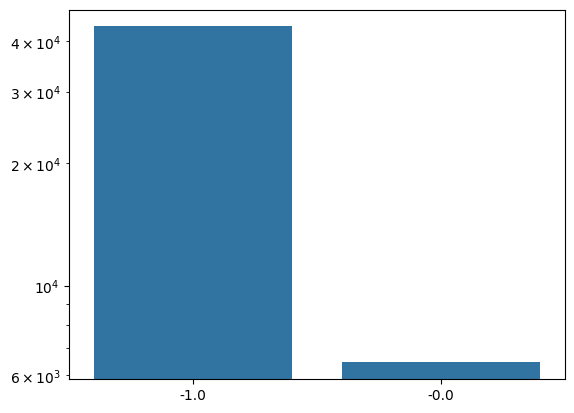

In [ ]:
try:
    final_costs = result_and_model[2]
except:
    final_costs = result_and_model["final_costs"]
final_costs_counter = Counter(final_costs)
sns.barplot(x=list(final_costs_counter.keys()), y=list(final_costs_counter.values()))
plt.yscale("log")
plt.show()

In [ ]:
epoch = []
cost = []
population = []
for e, c in costs.items():
    counter = Counter(c)
    for p, v in counter.items():
        epoch.append(e)
        cost.append(p)
        population.append(v)
df = pd.DataFrame({"epoch": epoch, "cost": cost, "population": population})

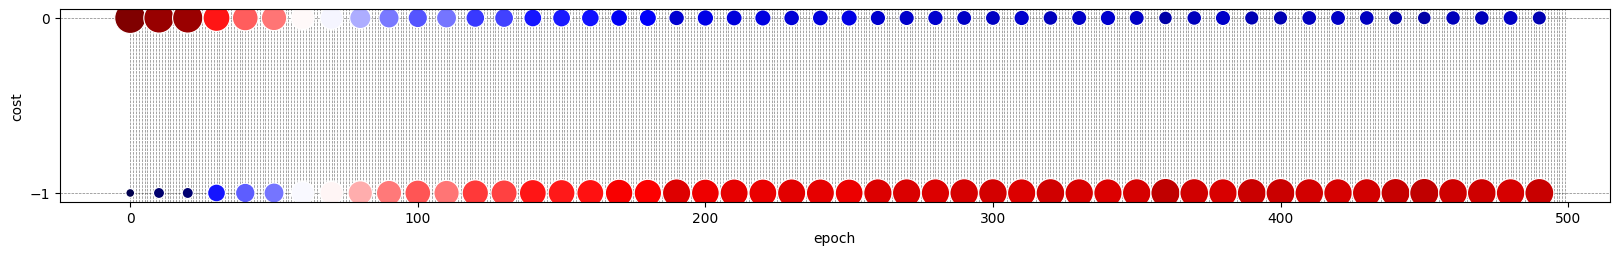

In [ ]:
fig, ax = plt.subplots(figsize=(20, 2.5))
sns.scatterplot(ax=ax, data=df[df.epoch%10 == 0], x="epoch", y="cost", size="population", hue="population", legend=False, sizes=(40, 500), palette="seismic")
unique_costs = df["cost"].unique()
ax.set_yticks(unique_costs)
for cost in unique_costs:
    ax.axhline(cost, color="black", linestyle="--", alpha=0.5, lw=0.5, zorder=0)
for epoch in df["epoch"].unique():
    ax.axvline(epoch, color="black", linestyle="--", alpha=0.5, lw=0.5, zorder=0)
plt.show()

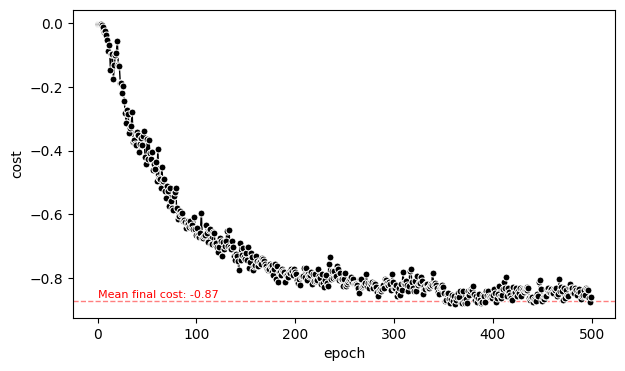

In [ ]:
fig, ax = plt.subplots(figsize=(7, 4))
sns.lineplot(ax=ax, data=df, x="epoch", y="cost", weights="population", lw=1, alpha=1, color="black", errorbar=None, marker="o", markersize=5)
ax.axhline(np.mean(final_costs), color="red", linestyle="--", alpha=0.5, lw=1, zorder=0)
ax.text(0, np.mean(final_costs)+0.01, f"Mean final cost: {np.mean(final_costs):.2f}", color="red", fontsize=8)
plt.show()


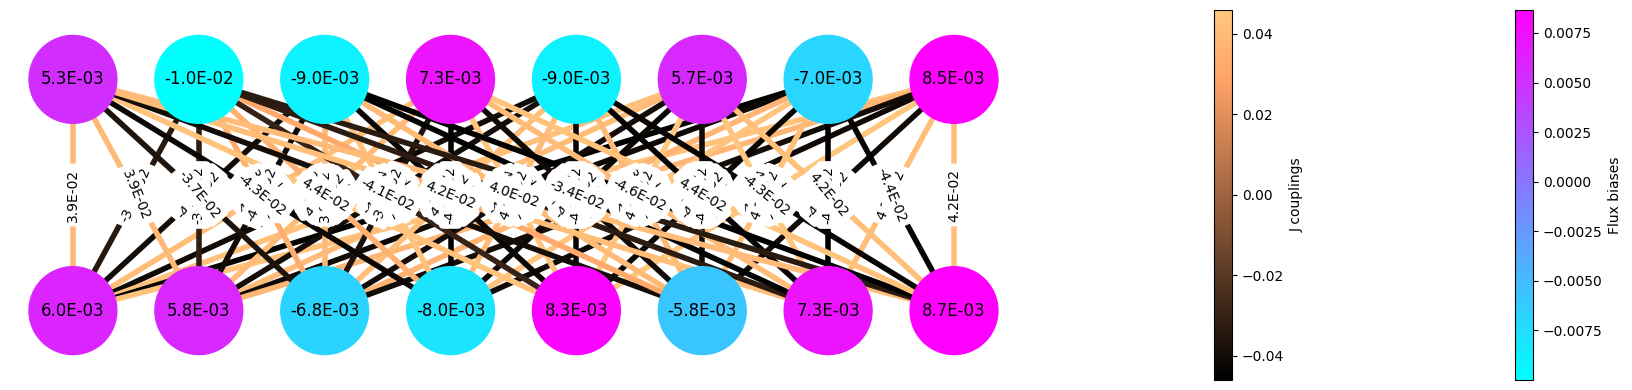

In [ ]:
fig, ax = plt.subplots(figsize=(18, 4))
try:
    result_and_model[1]._prior.plot()
except:
    result_and_model["lstm"]._prior.plot(ax=ax)

In [ ]:
parameters[0].keys()

dict_keys(['J_logical', 'flux_biases_logical', 'embedding', 'epoch'])

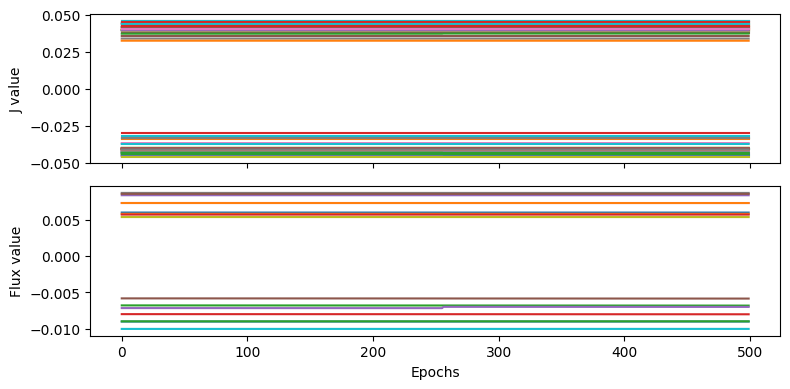

In [ ]:
J_params = {}
flux_params = {}
for i in range(len(parameters)):
    params = parameters[i]
    for edge, value in params["J_logical"].items():
        if edge not in J_params:
            J_params[edge] = []
        J_params[edge].append(value)
    for node, value in params["flux_biases_logical"].items():
        if node not in flux_params:
            flux_params[node] = []
        flux_params[node].append(value)

fig, axes = plt.subplots(figsize=(8, 4), nrows=2, sharex=True)
ax = axes[0]
for edge, values in J_params.items():
    ax.plot(values, label=edge)
#ax.legend()
ax.set_ylabel("J value")

ax = axes[1]
for node, values in flux_params.items():
    ax.plot(values, label=node)
ax.set_xlabel("Epochs")
ax.set_ylabel("Flux value")
#ax.legend()
plt.tight_layout()
#plt.savefig("qbag_param_evolution.pdf", dpi=300, bbox_inches="tight")
plt.show()
